In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random

from sklearn.datasets import load_files   
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.saving import load_model

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

/Users/briankim/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Loading Data

In [2]:
with open('./Data/X_train_v3.npy', 'rb') as f:
    X_train = np.load(f)
with open('./Data/y_train_v3.npy', 'rb') as f:
    y_train = np.load(f)
with open('./Data/X_test_v3.npy', 'rb') as f:
    X_test = np.load(f)
with open('./Data/y_test_v3.npy', 'rb') as f:
    y_test = np.load(f)
with open('./Data/shuffle_train_indices_v3.npy', 'rb') as f:
    train_indices = np.load(f)
with open('./Data/shuffle_test_indices_v3.npy', 'rb') as f:
    test_indices = np.load(f)
    
with open('./Data/data_classes.json', 'r') as f:
    data = json.load(f)

files = []
classes = []

for i in range(len(data)):
    if data[i][1] > -1:
        files.append(data[i][0])
        classes.append(data[i][1])

len(files), len(classes), X_train.shape, y_train.shape, X_test.shape, y_test.shape, train_indices.shape, test_indices.shape

(3290,
 3290,
 (2960, 200, 200, 3),
 (2960,),
 (329, 200, 200, 3),
 (329,),
 (2960,),
 (329,))

In [27]:
with open('./Data/data_2.json', 'r', encoding='UTF-8') as f:
    data = json.load(f)

book_links = data['book_links']
shelf_links = data['shelves']
shelf_values = data['shelf_values']
len(shelf_values)

10000

## Testing and per class

In [3]:
models = [name for name in os.listdir("./ModelSaves") if os.path.isdir("./ModelSaves/" + name) and not "_fh" in name and not "binary" in name and not "download" in name]
models

['ResNet50v2',
 'ResNet50v5_rus',
 'ResNet50v6_focal',
 'ResNet50v3',
 'ResNet50v4',
 'ResNet50v7_focal_sgd',
 'ResNet50v1_norm',
 'ResNet50v1',
 'VGG16v1',
 'VGG16_oversampling_v1',
 'ResNet50v1_norm_focal']

In [4]:
emotions = ["Happiness", "Sadness", "Fear", "Disgust", "Anger", "Surprise"]
num_classes = len(emotions)

In [5]:
y_test_eye = np.eye(num_classes)[y_test.reshape(-1)]

ResNet50v2
0.5623100303951368
Sadness [168, 231] 0.7272727272727273
Fear [16, 69] 0.2318840579710145
Happiness [1, 26] 0.038461538461538464
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


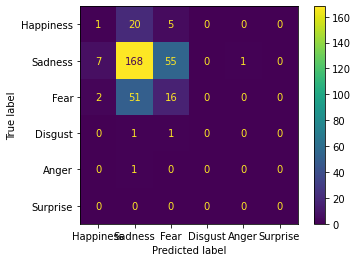

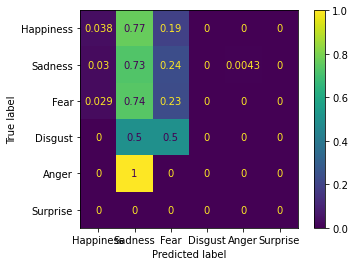

ResNet50v5_rus
0.0060790273556231
Sadness [1, 231] 0.004329004329004329
Fear [0, 69] 0.0
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [1, 1] 1.0


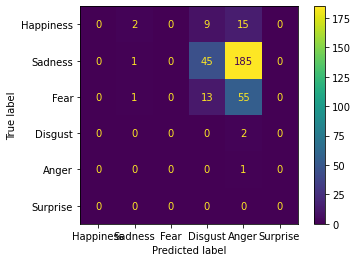

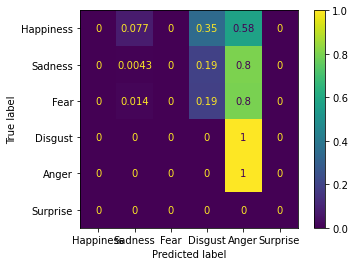

ResNet50v6_focal
0.7021276595744681
Sadness [231, 231] 1.0
Fear [0, 69] 0.0
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


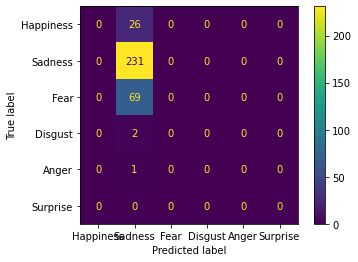

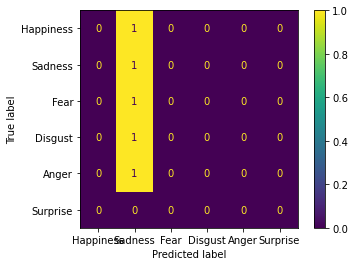

ResNet50v3
0.5835866261398176
Sadness [176, 231] 0.7619047619047619
Fear [14, 69] 0.2028985507246377
Happiness [2, 26] 0.07692307692307693
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


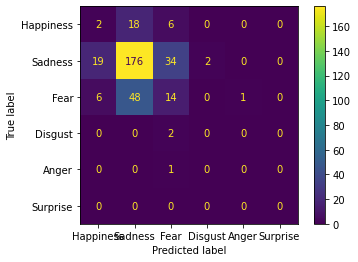

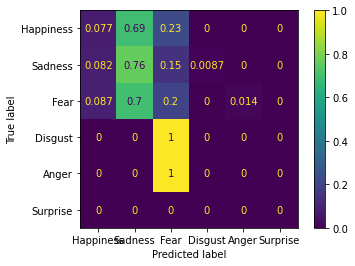

ResNet50v4
0.6200607902735562
Sadness [196, 231] 0.8484848484848485
Fear [7, 69] 0.10144927536231885
Happiness [1, 26] 0.038461538461538464
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


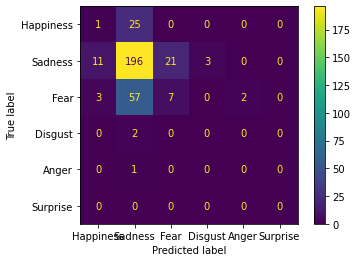

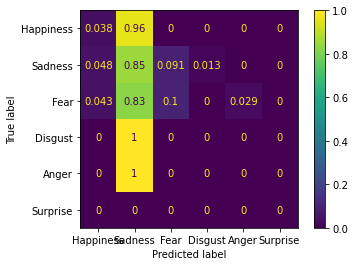

ResNet50v7_focal_sgd
0.6990881458966566
Sadness [229, 231] 0.9913419913419913
Fear [1, 69] 0.014492753623188406
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


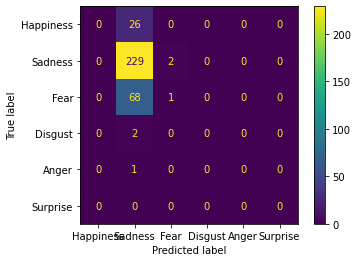

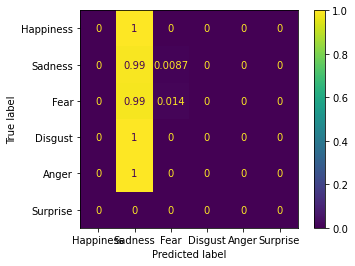

ResNet50v1_norm
0.6443768996960486
Sadness [207, 231] 0.8961038961038961
Fear [5, 69] 0.07246376811594203
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


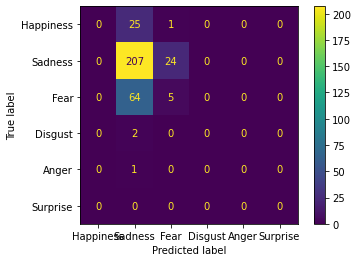

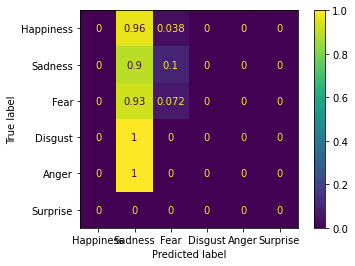

ResNet50v1
0.5835866261398176
Sadness [189, 231] 0.8181818181818182
Fear [3, 69] 0.043478260869565216
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


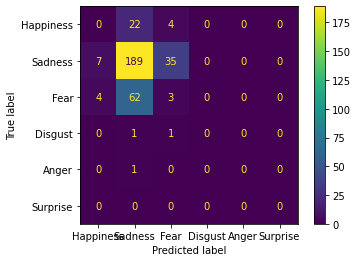

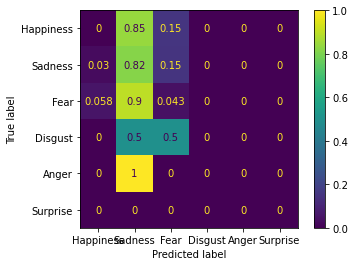

VGG16v1
0.6231003039513677
Sadness [195, 231] 0.8441558441558441
Fear [10, 69] 0.14492753623188406
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


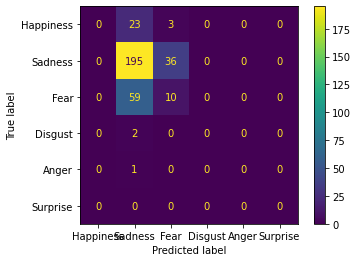

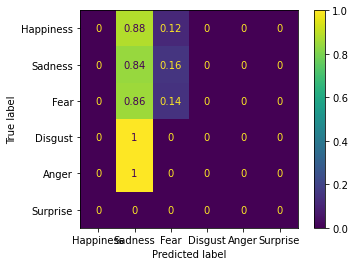

VGG16_oversampling_v1
0.601823708206687
Sadness [190, 231] 0.8225108225108225
Fear [7, 69] 0.10144927536231885
Happiness [1, 26] 0.038461538461538464
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


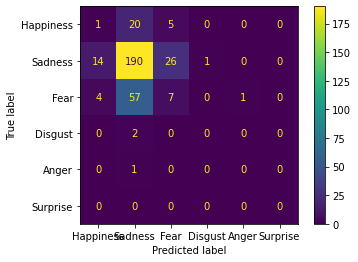

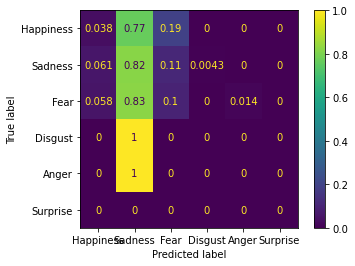

ResNet50v1_norm_focal
0.7021276595744681
Sadness [231, 231] 1.0
Fear [0, 69] 0.0
Happiness [0, 26] 0.0
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


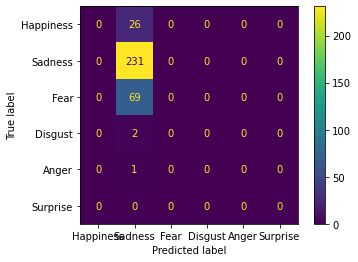

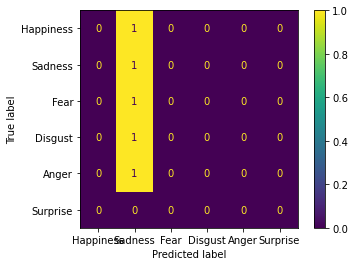

In [6]:
directory = "./ModelSaves/"
for model_name in models:
    print("=================================")
    print(model_name)
    model = load_model(directory + model_name)
    preds = model(X_test)
    print(np.sum(np.argmax(preds, axis=1) == np.argmax(y_test_eye, axis=1)) / len(y_test))
    
    scores = {}
    for i in range(len(y_test)):
        real_class = y_test[i]
        pred_class = np.argmax(preds[i])
        if real_class in scores:
            scores[real_class] = [scores[real_class][0] + int(real_class == pred_class), scores[real_class][1] + 1]
        else:
            scores[real_class] = [int(real_class == pred_class), 1]
            
    for key in list(scores.keys()):
        print(emotions[key], scores[key], scores[key][0] / scores[key][1])
        
    y_true = [emotions[i] for i in y_test]
    y_pred = [emotions[i] for i in np.argmax(preds, axis=1)]
    cm = confusion_matrix(y_true, y_pred, labels=emotions)
    cm_norm = confusion_matrix(y_true, y_pred, labels=emotions, normalize='true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
    disp.plot()
    plt.show()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=emotions)
    disp.plot()
    plt.show()

## Testing Binary and Multiclass

In [7]:
y_test_binary = np.array([0 if i != 1 else 1 for i in y_test])
y_test_binary_eye = np.eye(num_classes)[y_test_binary.reshape(-1)]

y_test_df = pd.Series(y_test)
test_mask = (y_test_df == 0) | (y_test_df == 2)
y_test_fh = y_test_df[test_mask]
y_test_fh = y_test_fh.replace(2,1)

In [8]:
model_bin = load_model('./ModelSaves/ResNet_binary_v2')
model_fh = load_model('./ModelSaves/ResNet_binary_fh_v3')

In [9]:
emotions_trunc =["Happiness", "Sadness", "Fear"]

preds_bin = model_bin(X_test)

non_sad_mask = pd.Series(np.argmax(preds_bin, axis=1)) != 1
sad_mask = pd.Series(np.argmax(preds_bin, axis=1)) == 1

hap_mask = pd.Series(np.argmax(y_test)) == 0
fear_mask = pd.Series(np.argmax(y_test)) == 2

print(X_test.shape, preds_bin.shape)
preds_fh = model_fh(X_test[non_sad_mask])

combined_preds = []

fh_i = 0
for i, val in enumerate(sad_mask):
    if val:
        combined_preds.append(np.argmax(preds_bin[i]))
    else:
        if np.argmax(preds_fh[fh_i]) == 1:
            combined_preds.append(2)
        else:
            combined_preds.append(np.argmax(preds_fh[fh_i]))
        fh_i += 1
        
print(len(y_test), len(combined_preds))

scores = {}
for i in range(len(y_test)):
    real_class = y_test[i]
    pred_class = combined_preds[i]
    if real_class in scores:
        scores[real_class] = [scores[real_class][0] + int(real_class == pred_class), scores[real_class][1] + 1]
    else:
        scores[real_class] = [int(real_class == pred_class), 1]

for key in list(scores.keys()):
    print(emotions[key], scores[key], scores[key][0] / scores[key][1])

(329, 200, 200, 3) (329, 5)
329 329
Sadness [226, 231] 0.9783549783549783
Fear [65, 69] 0.9420289855072463
Happiness [22, 26] 0.8461538461538461
Disgust [0, 2] 0.0
Anger [0, 1] 0.0


In [10]:
y_test.shape, np.array(combined_preds).shape

((329,), (329,))

In [11]:
counting = sum(np.array(y_test) == np.array(combined_preds))
print(counting, len(y_test), counting / len(y_test))

313 329 0.9513677811550152


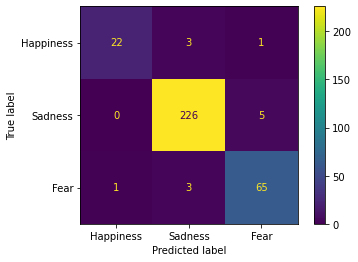

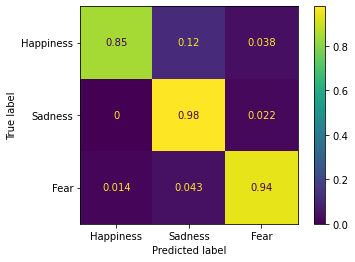

In [14]:
y_true = [emotions[i] for i in y_test]
y_pred = [emotions[i] for i in combined_preds]
cm = confusion_matrix(y_true, y_pred, labels=emotions_trunc)
cm_norm = confusion_matrix(y_true, y_pred, labels=emotions_trunc, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions_trunc)
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=emotions_trunc)
disp.plot()
plt.show()

[275 147  79  20 177 191 191 204 221 300]
/book/show/12137.Buried_Child


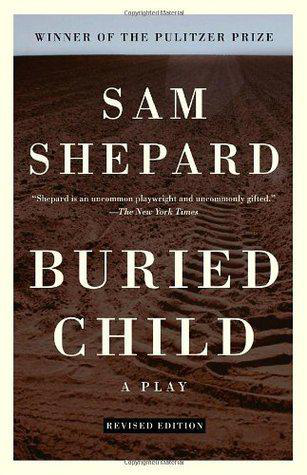

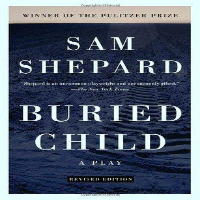

predict: Happiness
real: Happiness
/book/show/35216509-they-both-die-at-the-end


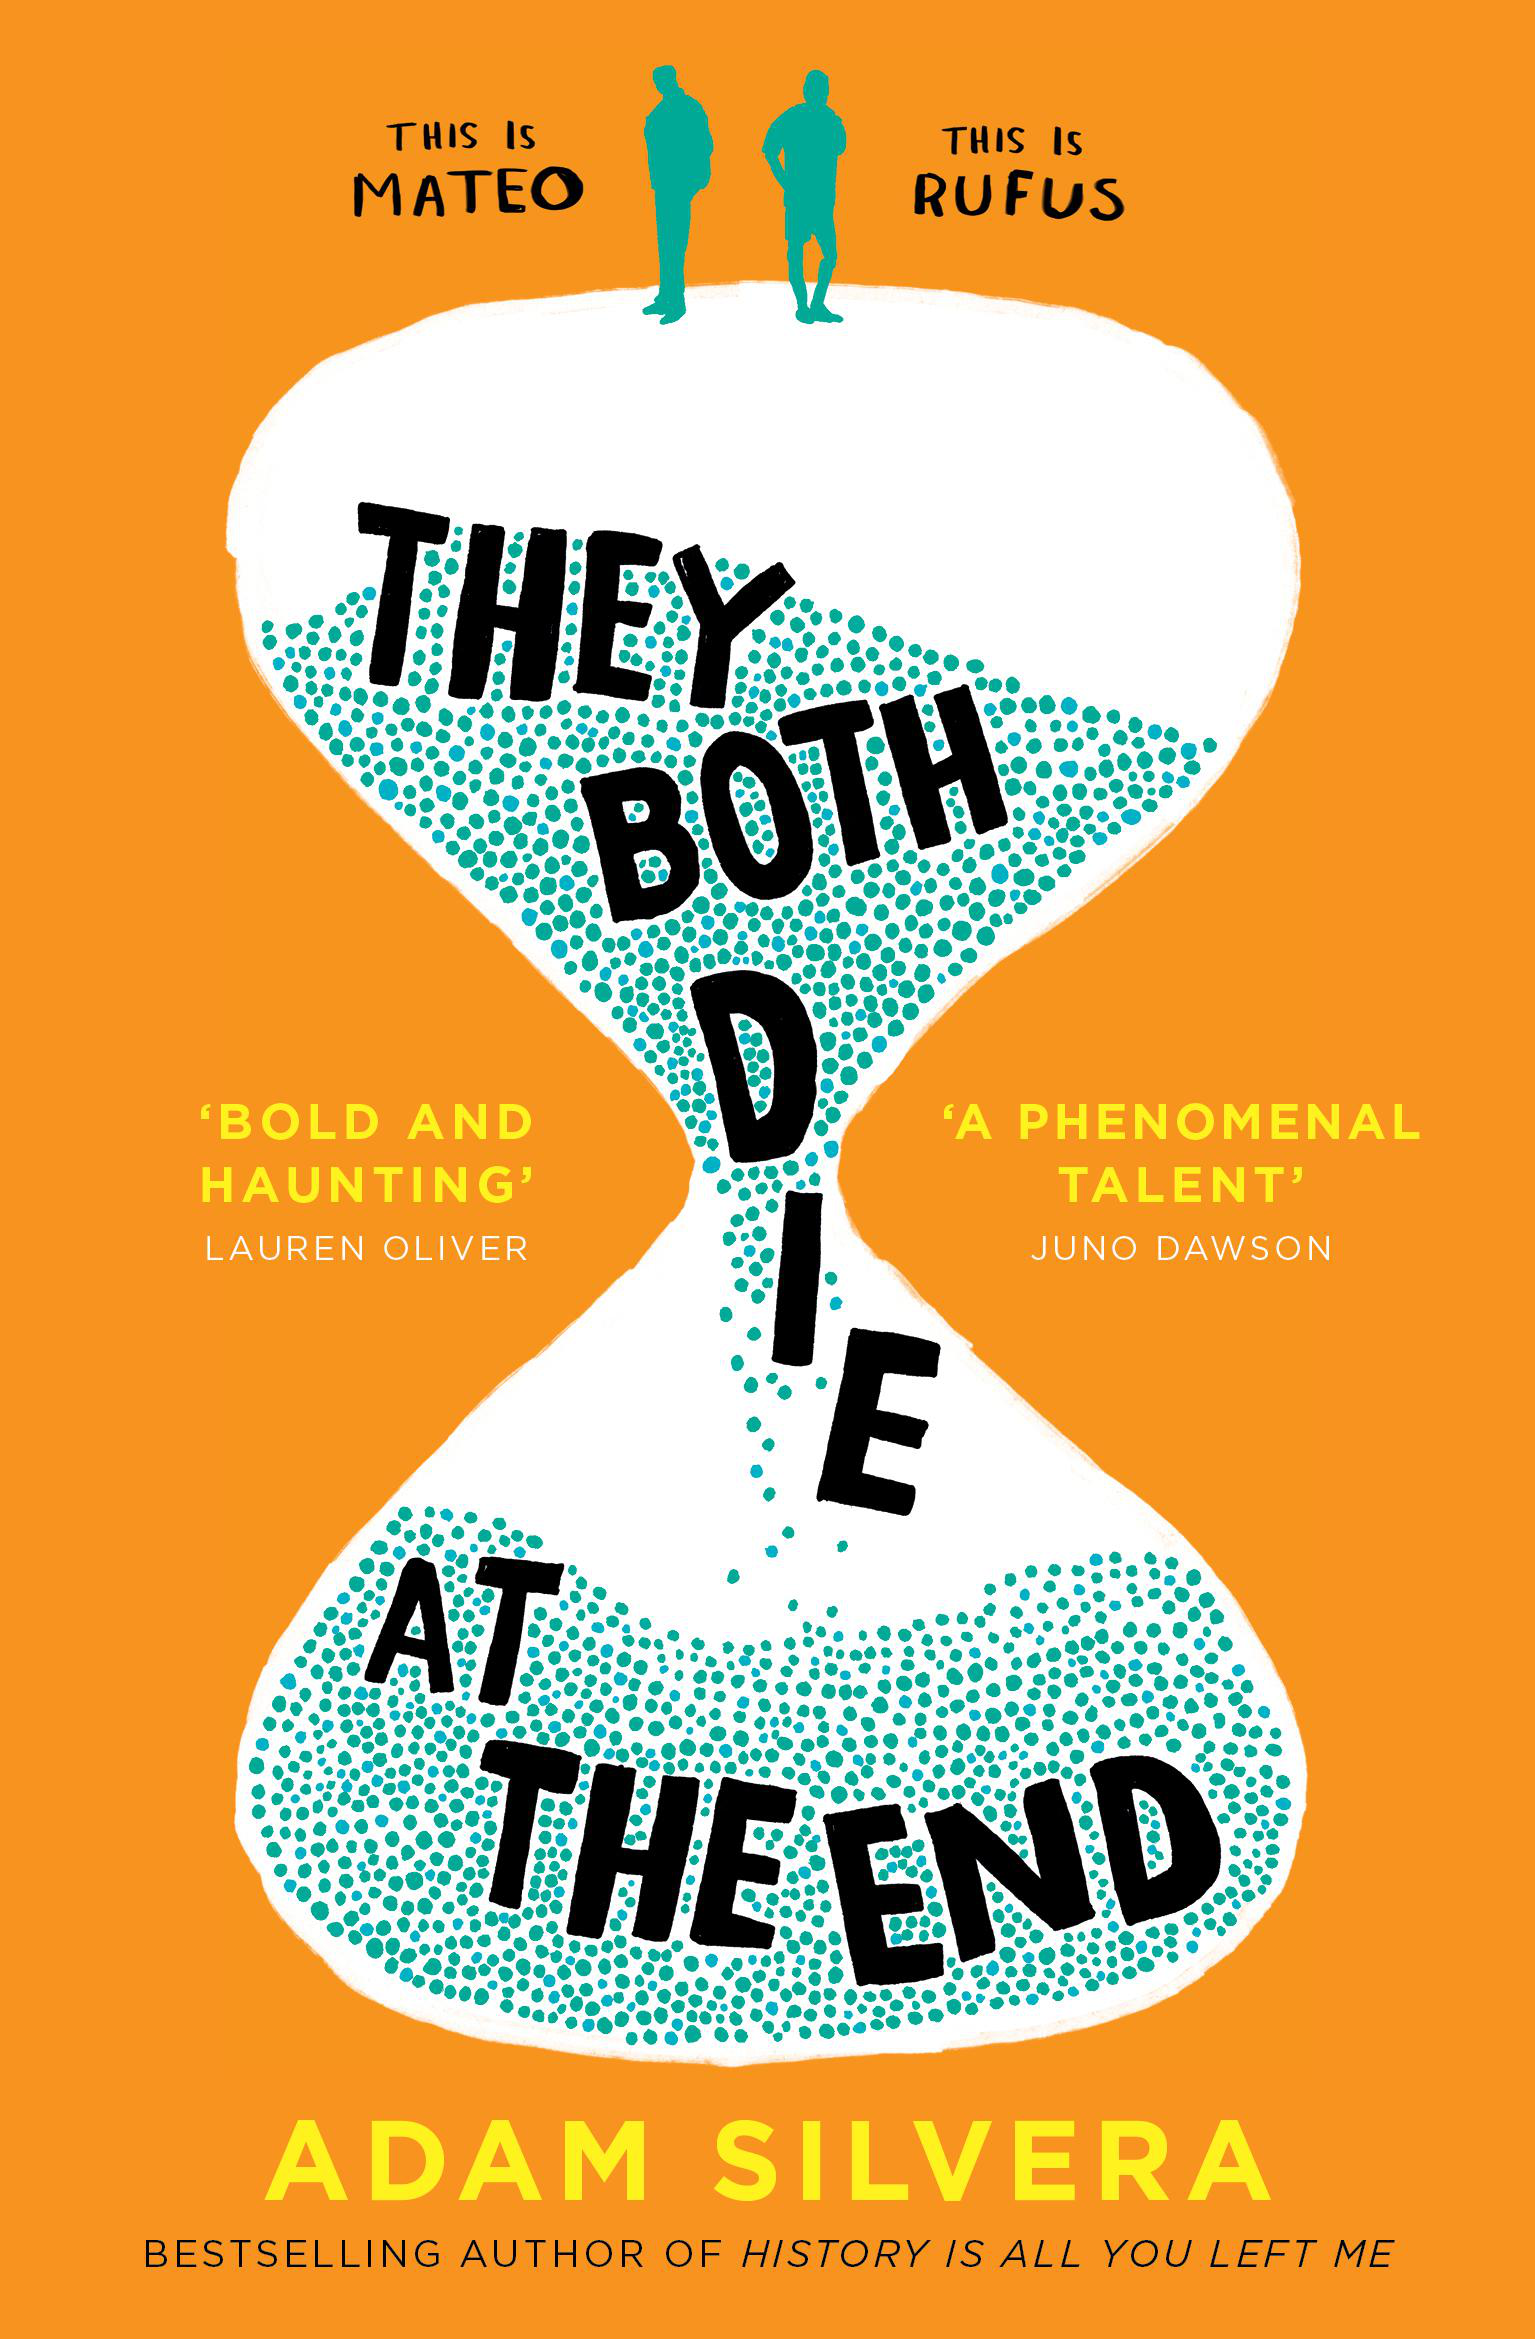

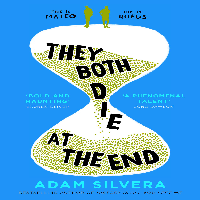

predict: Sadness
real: Sadness
/book/show/2373.The_Bone_Collector


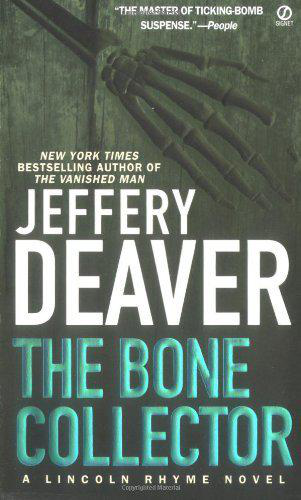

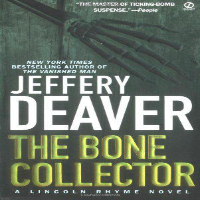

predict: Fear
real: Fear
/book/show/3097601-suicide-notes


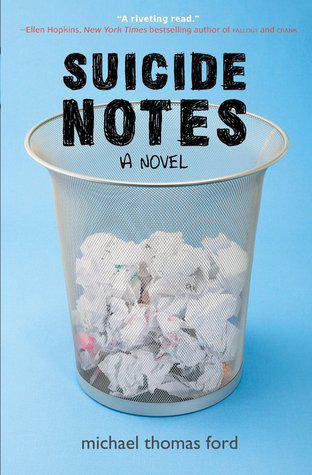

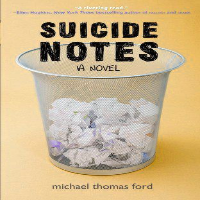

predict: Sadness
real: Sadness
/book/show/472343.Duma_Key


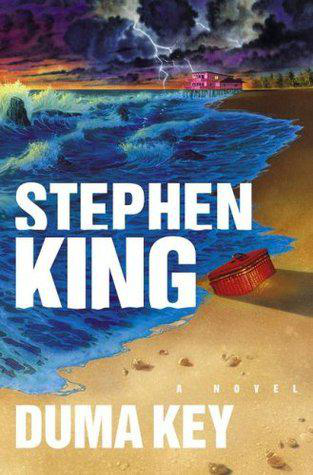

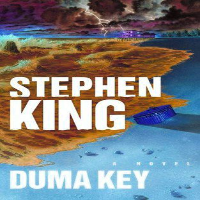

predict: Fear
real: Fear
/book/show/30226723-king-s-cage


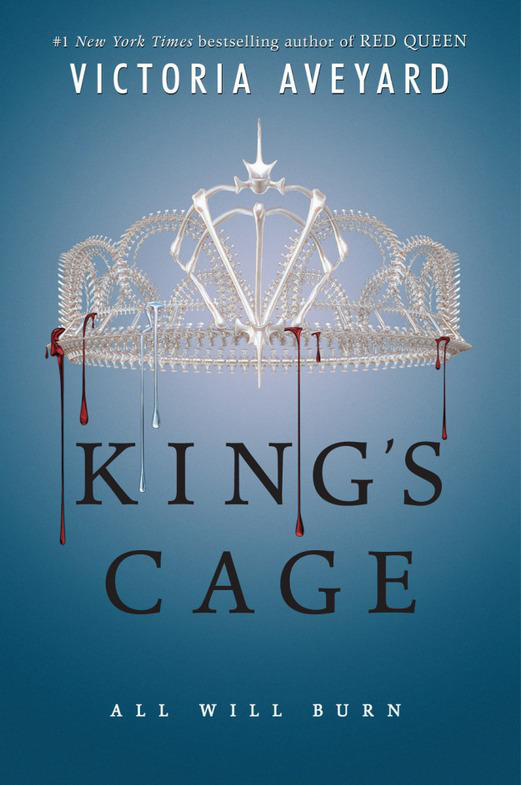

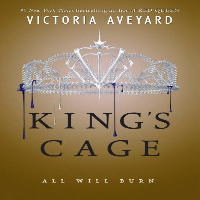

predict: Sadness
real: Sadness
/book/show/30226723-king-s-cage


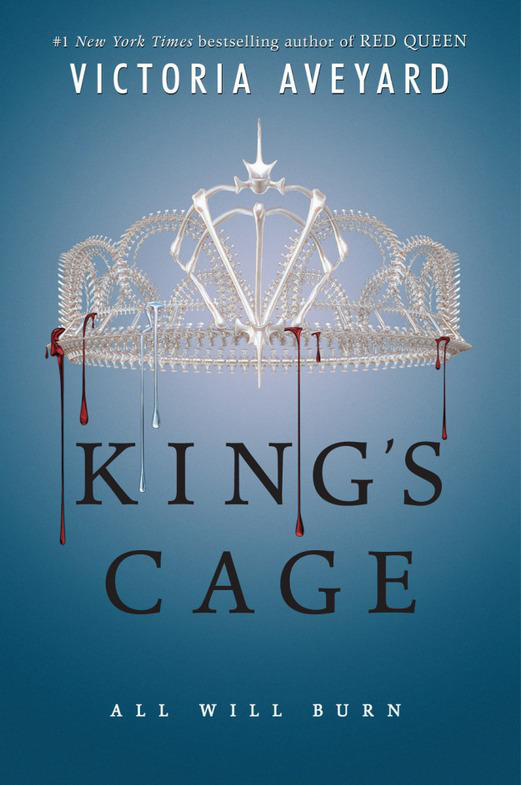

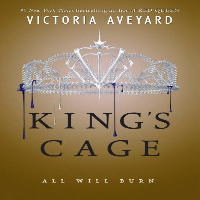

predict: Sadness
real: Sadness
/book/show/37187.The_Tiger_Rising


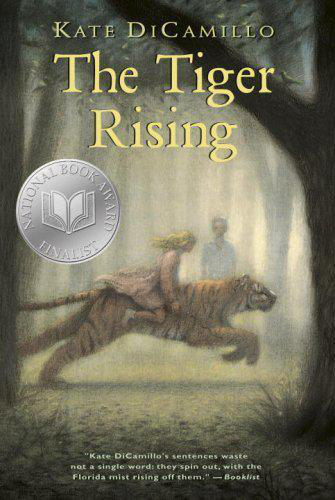

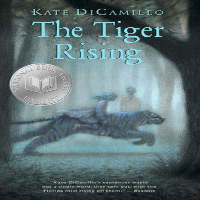

predict: Sadness
real: Sadness
/book/show/10866233-the-list


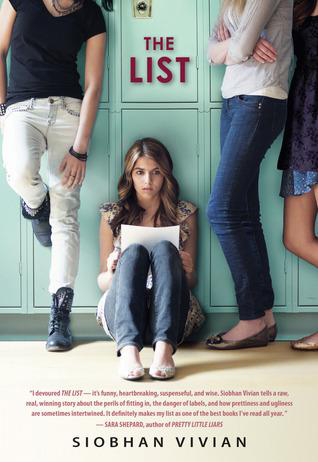

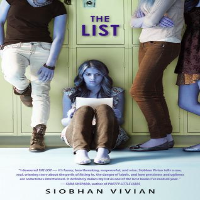

predict: Sadness
real: Sadness
/book/show/13538552-memoirs-of-an-imaginary-friend


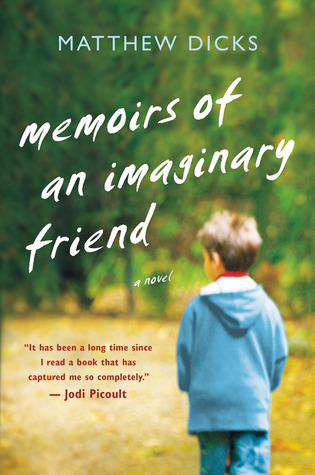

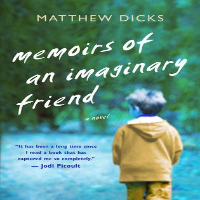

predict: Sadness
real: Sadness


In [37]:
sample_indices = np.random.choice(range(len(X_test)), size=10)
print(sample_indices)
directory = "./Data/data/images/"

for sample_index in sample_indices:
    print('========================================================')
    print(book_links[int(files[test_indices[sample_index]][:-4])])
    display(Image.open(directory + files[test_indices[sample_index]]))
    display(Image.fromarray((X_test[sample_index]).astype(np.uint8)))
    print("predict:", emotions_trunc[combined_preds[sample_index]])
    print("real:", emotions[classes[test_indices[sample_index]]])

[158 167  53 237 192  54 190 196   2 241]
/book/show/12609433-the-power-of-habit


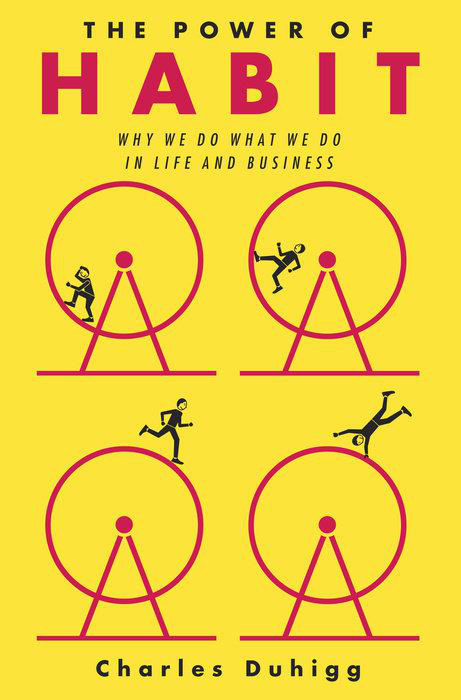

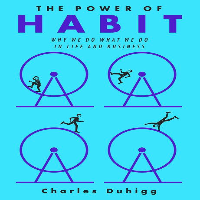

In [ ]:
sample_indices = np.random.choice(range(len(X_test)), size=10)
print(sample_indices)
directory = "./Data/data/images/"
emotion_set = set()

while len(emotion_set) < len(emotions_trunc):
    sample_index = np.random.choice(range(len(X_test)))
    if emotions_trunc[combined_preds[sample_index]] not in emotion_set:
        print('========================================================')
        print(book_links[int(files[test_indices[sample_index]][:-4])])
        display(Image.open(directory + files[test_indices[sample_index]]))
        display(Image.fromarray((X_test[sample_index]).astype(np.uint8)))
        print("predict:", emotions_trunc[combined_preds[sample_index]])
        print("real:", emotions[classes[test_indices[sample_index]]])
        
        emotion_set.add(emotions_trunc[combined_preds[sample_index]])